#### Описание задачи. Проект: Добыча золота - исследование технологического процесса
* Нам предстоит изучить технологический процесс восстановления золота.  
* Ниже представлена схема и основные характеристики, накопленные за определенный период времени.
* Задача - минимизировать количество убыточных предприятий, выбрать и посчитать метрики качества и научить моедль их предсказывать.

### Часть 1. Общее знакомство с датафреймом и условиями задачи

In [2]:
# Импорт бибилиотек
import pandas as pd
import numpy as np
from numpy.random import RandomState
import sweetviz as sv
import seaborn as sns
import pandas_profiling
from IPython.display import Image
import matplotlib.pyplot as plt
import missingno as msno
import plotly.express as px
import warnings
import plotly.figure_factory as ff
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer

warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
# Загрузка датафрейма
try:
    df_full = pd.read_csv('./datasets/gold_recovery_full_new.csv')
    df_train = pd.read_csv('./datasets/gold_recovery_train_new.csv')
    df_test = pd.read_csv('./datasets/gold_recovery_test_new.csv')
except:
    df_full = pd.read_csv('https://code.s3.yandex.net/datasets/gold_recovery_full_new.csv')
    df_train = pd.read_csv('https://code.s3.yandex.net/datasets/gold_recovery_train_new.csv')
    df_test = pd.read_csv('https://code.s3.yandex.net/datasets/gold_recovery_test_new.csv')

In [4]:
print(df_train.shape)
print(df_test.shape)
print(df_full.shape)

(14149, 87)
(5290, 53)
(19439, 87)


В тестовой выборке меньше колонок, чем в остальных на 34
Посмотрим что это за поля

In [5]:
lost_cols = []
for col in df_full.columns:
    if col not in df_test.columns: lost_cols.append(col)
print ('Количество столбцов, которых нет в df_test: ', len(lost_cols))
print ('Всего столбцов, в df_train: ', len(df_train.columns))
print ('Оставшееся количество столбцов', len(df_train.columns)-len(lost_cols))
lost_cols

Количество столбцов, которых нет в df_test:  34
Всего столбцов, в df_train:  87
Оставшееся количество столбцов 53


['final.output.concentrate_ag',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.concentrate_au',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'final.output.tail_au',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'primary_cleaner.output.tail_au',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.au_pb_ratio',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.concentrate_au',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_pb',
 'rougher.output.ta

1. Мы видим, что все поля, которых нет в df_test содержат в себе параметр output, это может говорить о том, что параметры продукта нам известны только в обучающей выборке, а в тестовой нам эти параметры не дают.  
Список новых полей достаточно большой. Будет полезным оставить здесь краткую информацию о процессах.  

--------------------------
Стадии:
* rougher — флотация
* primary_cleaner — первичная очистка
* secondary_cleaner — вторичная очистка
* final — финальные характеристики
-------------------------------
Параметры:
* input — параметры сырья
* output — параметры продукта
* state — параметры, характеризующие текущее состояние этапа
* calculation — расчётные характеристики

In [6]:
display('Технологический процесс', Image(url='https://pictures.s3.yandex.net/resources/viruchka_1576238830.jpg',width = 800))

'Технологический процесс'

1. **Флотация**
Во флотационную установку подаётся смесь золотосодержащей руды. После обогащения получается черновой концентрат и «отвальные хвосты», то есть остатки продукта с низкой концентрацией ценных металлов.
На стабильность этого процесса влияет непостоянное и неоптимальное физико-химическое состояние флотационной пульпы (смеси твёрдых частиц и жидкости).
2. **Очистка** 
Черновой концентрат проходит две очистки. На выходе получается финальный концентрат и новые отвальные хвосты.

In [7]:
display('Эффективность обогащения рассчитывается по формуле', Image(url='https://pictures.s3.yandex.net/resources/Recovery_1576238822.jpg',width = 800))

'Эффективность обогащения рассчитывается по формуле'

* C — доля золота в концентрате после флотации/очистки;
* F — доля золота в сырье/концентрате до флотации/очистки;
* T — доля золота в отвальных хвостах после флотации/очистки.

Другие признаки (Технологический процесс):  

* Rougher feed — исходное сырье
* Rougher additions (или reagent additions) — флотационные реагенты: Xanthate, Sulphate, Depressant
* Xanthate **— ксантогенат (промотер, или активатор флотации);
* Sulphate — сульфат (на данном производстве сульфид натрия);
* Depressant — депрессант (силикат натрия).
* Rougher process (англ. «грубый процесс») — флотация
* Rougher tails — отвальные хвосты
* Float banks — флотационная установка
* Cleaner process — очистка
* Rougher Au — черновой концентрат золота
* Final Au — финальный концентрат золота

-------------------
* air amount — объём воздуха
* fluid levels — уровень жидкости
* feed size — размер гранул сырья
* feed rate — скорость подачи

In [8]:
display('Метрика sMAPE вычисляется так:', Image(url='https://pictures.s3.yandex.net/resources/smape_1576238825.jpg',width = 800))

'Метрика sMAPE вычисляется так:'

In [9]:
display('Итоговая метрика складывается из двух величин::', Image(url='https://pictures.s3.yandex.net/resources/_smape_1576238814.jpg',width = 800))

'Итоговая метрика складывается из двух величин::'

#### Вывод после ознакомления с датафреймом и технологическим процессом.
1. У нас 2 больших этапа, на выходе из которых на этапе мы получаем черновой концентрат (rough), после чего из него получается финальный продукт (final)
2. Нам нужно будет проверить качество данных, после чего для каждого из этапов разработать модель, позволяющую предсказывать итог с минимальным mApe (относительный MAP)
3. После предобработки данных нам потребуется разбить все признаки по этапам, выполнить предобработку, после чего подобрать наилучший вид модели с наилучшими глобальными параметрами.

In [10]:
pd.options.display.max_rows = 100
pd.options.display.max_columns = 100
dataframes = [df_train,df_full,df_test] #На протяжении проекты мы будем работать 3 датафреймами, удобно будет создать список для функций.
def null_df(df):
    return (
    df.isna()
        .sum()
        .sort_values(ascending=False)
        .loc[lambda x: x > 0]
        .to_frame())


df = null_df(df_train)
df.columns = ['missed_values']
df


,missed_values
secondary_cleaner.output.tail_sol,1605
rougher.state.floatbank10_e_air,436
rougher.input.floatbank11_xanthate,428
primary_cleaner.output.concentrate_sol,286
secondary_cleaner.state.floatbank2_a_air,217
final.output.concentrate_sol,211
rougher.input.feed_size,144
primary_cleaner.input.xanthate,100
rougher.input.feed_pb,100
final.output.tail_pb,100


In [11]:
df_category = pd.DataFrame(df_train.columns)
df_category[['stage','parametr','product']]=df_category[0].str.split('.',expand=True)
df_category = df_category.drop([0], axis = 1)
display(df_category.groupby(['stage','parametr']).count())


product
stage             parametr            
final             output             9
primary_cleaner   input              4
                  output             8
                  state              8
rougher           calculation        4
                  input             10
                  output             9
                  state             12
secondary_cleaner output             4
                  state             18

Ну вот теперь список параметров начинает поддаваться пониманию.  
Мы видим:
* На финальной стадии есть только параметры output
* На предшествующем этапе есть доп. параметр output
* Больше всего параметров на этапе флотации - 35, на 1 чисткее - 20, на 2 чистке - 22, на финальной - 9
* calculation есть только на этапе roughter

In [12]:
df_pivot = pd.pivot_table(
    data = df_category
    ,columns=df_category['stage']
    ,aggfunc='count'
    ,index='product',).reset_index()
df_pivot.columns = ['product','final','primary_cleaner','rougher','secondary_cleaner']
df_pivot = df_pivot.fillna(0)
df_pivot = df_pivot.reset_index(drop = True)
#df_pivot[df_pivot['final']!= 0]
display('Выходные данные этапа флотации',df_pivot[df_pivot['rougher']!=0])
display('Выходные данные финального этапа',df_pivot[df_pivot['final']!=0])

'Выходные данные этапа флотации'

,product,final,primary_cleaner,rougher,secondary_cleaner
0,au_pb_ratio,0.0,0.0,1.0,0.0
1,concentrate_ag,1.0,1.0,1.0,0.0
2,concentrate_au,1.0,1.0,1.0,0.0
3,concentrate_pb,1.0,1.0,1.0,0.0
4,concentrate_sol,1.0,1.0,1.0,0.0
6,feed_ag,0.0,0.0,1.0,0.0
7,feed_au,0.0,0.0,1.0,0.0
8,feed_pb,0.0,0.0,1.0,0.0
9,feed_rate,0.0,0.0,1.0,0.0
10,feed_size,0.0,1.0,1.0,0.0


'Выходные данные финального этапа'

,product,final,primary_cleaner,rougher,secondary_cleaner
1,concentrate_ag,1.0,1.0,1.0,0.0
2,concentrate_au,1.0,1.0,1.0,0.0
3,concentrate_pb,1.0,1.0,1.0,0.0
4,concentrate_sol,1.0,1.0,1.0,0.0
56,recovery,1.0,0.0,1.0,0.0
59,tail_ag,1.0,1.0,1.0,1.0
60,tail_au,1.0,1.0,1.0,1.0
61,tail_pb,1.0,1.0,1.0,1.0
62,tail_sol,1.0,1.0,1.0,1.0


Теперь еще проще будет брать данные для каждого этапа. Также обратил внимание на следующее:
* Параметры tail есть на всех 4 этапах - это остатки
* Параметры concentrate есть на всех этапах кроме secondary cleaner

#### Вывод после анализа столбцов:
* Нам удалось струтурировать столбцы
* Понять, на каких этапах, какие данные мы получаем.
* Понять какие продукты на какой стадии встречаются.
* В перспективе мы готовы создавать модели для нужных этапов.

#### Задание 1.2 Проверьте, что эффективность обогащения рассчитана правильно
* Проверьте, что эффективность обогащения рассчитана правильно. Вычислите её на обучающей выборке для признака rougher.output.recovery. Найдите MAE между вашими расчётами и значением признака. Опишите выводы.

In [13]:
display('Эффективность обогащения рассчитывается по формуле', Image(url='https://pictures.s3.yandex.net/resources/Recovery_1576238822.jpg',width = 800))

'Эффективность обогащения рассчитывается по формуле'

C — доля золота в концентрате после флотации/очистки;  
F — доля золота в сырье/концентрате до флотации/очистки;  
T — доля золота в отвальных хвостах после флотации/очистки.

Нам надо понять какие конретно столбцы соответствуют C,F,T для

In [14]:
# Функция расчета рекавери
def calc_recovery(df,C,F,T):
    return (df[C]*(df[F]-df[T]))/(df[F]*(df[C]-df[T]))*100

In [15]:
df_train.filter(like = 'rougher',axis=1).isna().sum()

rougher.calculation.sulfate_to_au_concentrate           1
rougher.calculation.floatbank10_sulfate_to_au_feed      1
rougher.calculation.floatbank11_sulfate_to_au_feed      1
rougher.calculation.au_pb_ratio                         0
rougher.input.feed_ag                                   0
rougher.input.feed_pb                                 100
rougher.input.feed_rate                                 8
rougher.input.feed_size                               144
rougher.input.feed_sol                                 78
rougher.input.feed_au                                   0
rougher.input.floatbank10_sulfate                      29
rougher.input.floatbank10_xanthate                      8
rougher.input.floatbank11_sulfate                      36
rougher.input.floatbank11_xanthate                    428
rougher.output.concentrate_ag                           0
rougher.output.concentrate_pb                           0
rougher.output.concentrate_sol                         22
rougher.output

* Отличная новость, столбец output_concentrate_au без пропусков, соответственно его можно использовать для расчета без обработки пропусков. Он и есть - C
* Столбец input.feed_au также не содержит пропусков, это - F
* Столбец rougher.output.tail_au  не содержит пропусков, это - T

In [16]:
c = 'rougher.output.concentrate_au'
f = 'rougher.input.feed_au'
t = 'rougher.output.tail_au'
df_train['rougher.output.recovery.calc']=calc_recovery(df_train,c,f,t)
df_train[['rougher.output.recovery','rougher.output.recovery.calc']].sample(10)

,rougher.output.recovery,rougher.output.recovery.calc
9751,86.251479,86.251479
7384,85.971801,85.971801
4979,84.582282,84.582282
5179,88.300952,88.300952
2530,80.485370,80.485370
11057,93.408584,93.408584
12165,82.956265,82.956265
3432,75.729313,75.729313
8057,82.482630,82.482630
10486,94.792707,94.792707


На первый взгляд данные похожи, но мы посмотрели только 10 значений, надо проверить, а есть ли строки, где значения не совпали

In [17]:
#Посчитаем количество строк, где расчетные данные и изначальные не совпали
print ('Размер train_df: ',len(df_train))
print('Количество расхождений: ', len(df_train[df_train['rougher.output.recovery'] != df_train['rougher.output.recovery.calc']]))

Размер train_df:  14149
Количество расхождений:  7437


Примерно половина значений не совпали точь в точь.
Посчитаем МАЕ

In [18]:
print('МАЕ rougher.output.recovery и rougher.output.recovery.calc = ',mean_absolute_error(
    df_train['rougher.output.recovery'], 
    df_train['rougher.output.recovery.calc']))
    

МАЕ rougher.output.recovery и rougher.output.recovery.calc =  9.73512347450521e-15


Мы получили крайне низкое значение МАЕ, из чего можно сделать вывод, что в датафрейме расчет рекавери сделан верно с незначительной погрешностью, которой можно пренебречь, это же мы увидели при сравнении 10 случайных значений.  
#### Задание 1.3 Проанализируйте признаки, недоступные в тестовой выборке. Что это за параметры? К какому типу относятся?
Ранее мы выводили список полей, которых нет в test_df. Там можно было обратить внимание на то, что из test df исключены значения output.
Также в test данных нет значений столбцов:
* rougher.calculation.sulfate_to_au_concentrate
* rougher.calculation.floatbank10_sulfate_to_au_feed
* rougher.calculation.floatbank11_sulfate_to_au_feed
* rougher.calculation.au_pb_ratio

Предобработку будем выполнять для данных, которые будем использовать для обучения модели, для этого необходимо подготовить итоговый список

In [19]:
print(len(df_test.columns))
df_test.isna().sum()

53


date                                           0
primary_cleaner.input.sulfate                  4
primary_cleaner.input.depressant               5
primary_cleaner.input.feed_size                0
primary_cleaner.input.xanthate                 4
primary_cleaner.state.floatbank8_a_air         0
primary_cleaner.state.floatbank8_a_level       0
primary_cleaner.state.floatbank8_b_air         0
primary_cleaner.state.floatbank8_b_level       0
primary_cleaner.state.floatbank8_c_air         0
primary_cleaner.state.floatbank8_c_level       0
primary_cleaner.state.floatbank8_d_air         0
primary_cleaner.state.floatbank8_d_level       0
rougher.input.feed_ag                          0
rougher.input.feed_pb                          0
rougher.input.feed_rate                        3
rougher.input.feed_size                        1
rougher.input.feed_sol                        21
rougher.input.feed_au                          0
rougher.input.floatbank10_sulfate              5
rougher.input.floatb

Основные типы столбцов - признаков:
* State
* Input

In [20]:
print('Количество столбцов state(состояния) = ', len(df_test.filter(like = 'state', axis=1).columns))
print('Количество столбцов input(параметры сырья) = ', len(df_test.filter(like = 'input', axis=1).columns))
print ('В столбце date пропусков нет, также мы не будем использовать их для обучения')

Количество столбцов state(состояния) =  38
Количество столбцов input(параметры сырья) =  14
В столбце date пропусков нет, также мы не будем использовать их для обучения


In [21]:
train_cols = df_test.columns

Итого получили 52 столбца признаков для обучения, произведем предобработку.
#### Задание 1.4 Проведите предобработку данных.

In [22]:
start_df = len(df_train)
print('Изначальный размер датафрейма',start_df)

Изначальный размер датафрейма 14149


In [23]:
df_train[train_cols].duplicated().sum()

0

Явных дубликатов нет.

In [24]:

(df_train[train_cols]
    .isna()
    .sum()
    .sort_values(ascending=False))

rougher.state.floatbank10_e_air               436
rougher.input.floatbank11_xanthate            428
secondary_cleaner.state.floatbank2_a_air      217
rougher.input.feed_size                       144
rougher.input.feed_pb                         100
primary_cleaner.input.xanthate                100
rougher.input.feed_sol                         78
rougher.input.floatbank11_sulfate              36
primary_cleaner.input.depressant               32
rougher.input.floatbank10_sulfate              29
secondary_cleaner.state.floatbank2_b_air       21
primary_cleaner.input.sulfate                  20
rougher.input.floatbank10_xanthate              8
rougher.input.feed_rate                         8
secondary_cleaner.state.floatbank4_a_air        6
primary_cleaner.state.floatbank8_b_air          4
primary_cleaner.state.floatbank8_a_air          4
secondary_cleaner.state.floatbank3_a_air        4
primary_cleaner.state.floatbank8_d_air          3
primary_cleaner.state.floatbank8_c_air          2


Большинство столбцов содержат незначительное количество пропусков, удалим строки, где кол-во пропусков менее 20

In [25]:
columns_to_dropna = (df_train[train_cols]
    .isna()
    .sum()
    .to_frame())
columns_to_dropna.columns = ['missing_values']
columns_to_dropna = columns_to_dropna[columns_to_dropna['missing_values']<20].index
df_train = df_train.dropna(subset=columns_to_dropna)
print ('Оставшиеся столбцы с пропусками')
missing_to_work = (df_train[train_cols]
    .isna()
    .sum()[df_train[train_cols].isna().sum() > 0]
    .sort_values(ascending= False))
print(missing_to_work)
print('Итоговая потеря данных: {:d.}', 1-len(df_train)/start_df)


Оставшиеся столбцы с пропусками
rougher.state.floatbank10_e_air             433
rougher.input.floatbank11_xanthate          418
secondary_cleaner.state.floatbank2_a_air    215
rougher.input.feed_size                     143
rougher.input.feed_pb                       100
primary_cleaner.input.xanthate               91
rougher.input.feed_sol                       70
rougher.input.floatbank11_sulfate            32
primary_cleaner.input.depressant             27
rougher.input.floatbank10_sulfate            20
primary_cleaner.input.sulfate                13
secondary_cleaner.state.floatbank2_b_air     12
dtype: int64
Итоговая потеря данных: {:d.} 0.002049614813767753


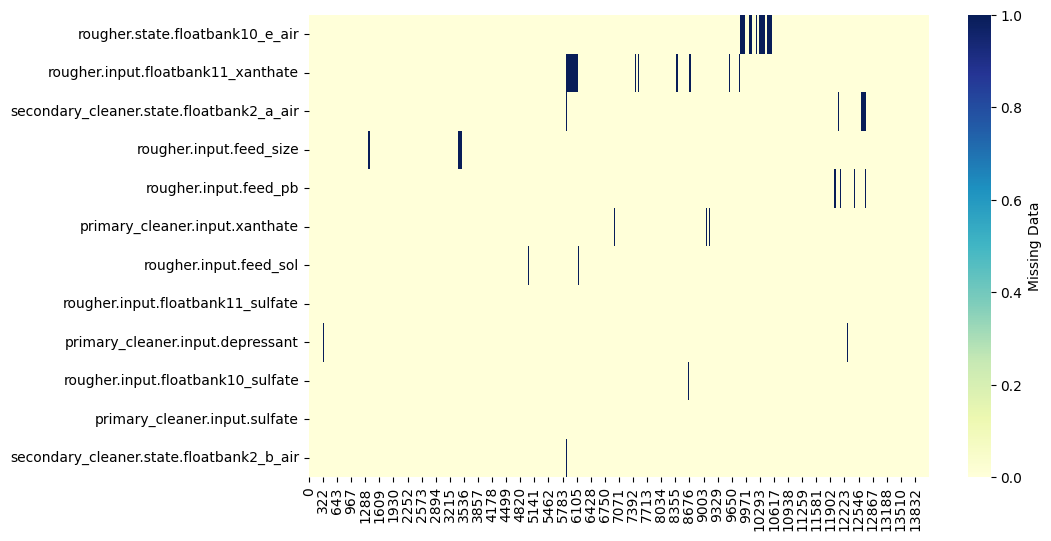

In [26]:
#sns.heatmap(df[missing_to_work.index].isnull(), cmap=sns.color_palette(colours))
df_111 = df_train[missing_to_work.index]
plt.figure(figsize=(10,6))
sns.heatmap(df_111.isna().transpose(),
            cmap="YlGnBu",
            cbar_kws={'label': 'Missing Data'})
plt.show()


* Из условия известно, что соседние значения схожи, при этом мы видим, что есть участки, где пропуски расположены кучно и заполнение их предыдущим значением может внести сильную погрешность. Смущают следующие поля:
  * rougher.state.floatbank10_e_air
  * rougher.input.floatbank11_xanthate
  * secondary_cleaner.state.floatbank2_a_air 
  * rougher.input.feed_size 

In [27]:
fig = px.line(df_111, x=df_111.index, y=df_111['rougher.state.floatbank10_e_air'],width=970)
fig.show()

Глядя на график в голове появилась идея заполнить пропуски другой моделью, но не знаю, делают ли так вообще, можно ли условно в зависимости от даты сделать трейн выборку по аналогии с прогнозом по дате, а потом заполнить пропуски таким образом. Пока мозгов не хватило, чтобы так сделать.  
На текущей стадии пробую заполнить все пропуски методом ffill? но перед этим нужно 

In [28]:
df_train[train_cols] = df_train[train_cols].ffill(axis=0)

In [29]:
#df_train[train_cols].info()
print('Итоговая потеря данных: {:d.}', 1-len(df_train)/start_df)

Итоговая потеря данных: {:d.} 0.002049614813767753


### Часть 2. Анализ данных
#### 2.1. Посмотрите, как меняется концентрация металлов (Au, Ag, Pb) на различных этапах очистки. Опишите выводы.
Всего у нас 4 стадии:
1. Изначальная концентрация
2. Концентрация после флотации
3. Концентрация после первичной очистки
4. Итоговая концентрация

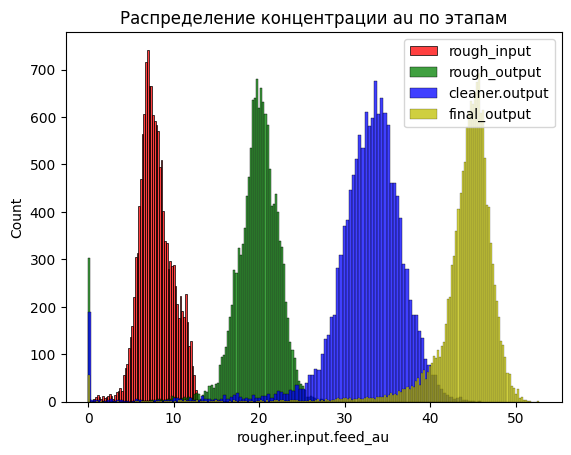

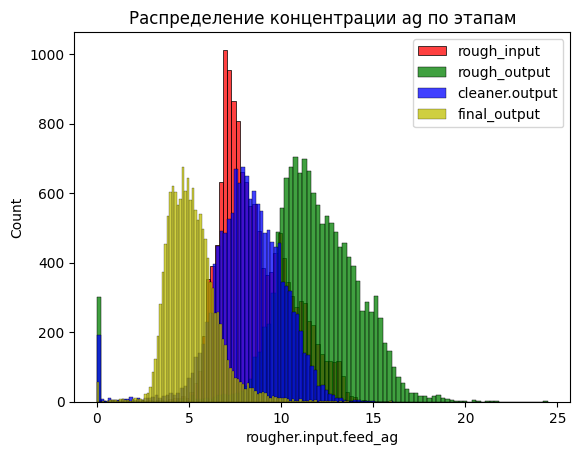

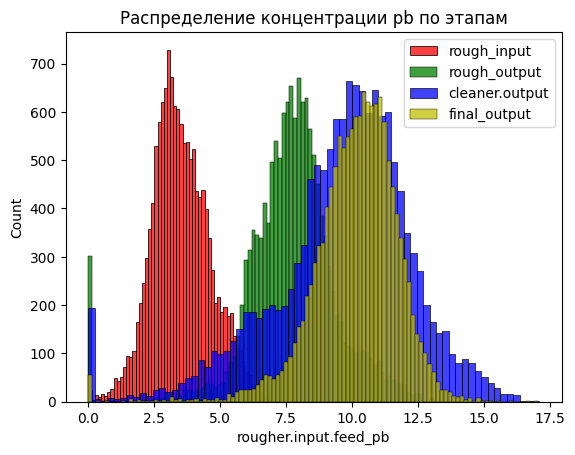

In [30]:
def graph (metal):
    sns.histplot(df_train[f'rougher.input.feed_{metal}'], color='r', label='rough_input', kde=False)
    sns.histplot(df_train[f'rougher.output.concentrate_{metal}'], color='g', label='rough_output', kde=False)
    sns.histplot(df_train[f'primary_cleaner.output.concentrate_{metal}'], color='b', label='cleaner.output', kde=False)
    sns.histplot(df_train[f'final.output.concentrate_{metal}'], color='y', label='final_output', kde=False)
    plt.title(f'Распределение концентрации {metal} по этапам')
    plt.legend(loc = 'upper right')
    plt.show()

    
for metal in ['au','ag','pb']:
    graph(metal)

Из графиков сделал следующие выводы:
1. Концентрация au с каждым этапом растет, что логично. 
2. Концентрация ag на входе находится на стабильно высоком уровне, затем вырастает после этапа флотации, затеи начинает падать на этапе чистки и финальной стадии
3. Концентрация pb в начеле незначительна, затем вырастает скорее всего за счет снижения доли ag в общей массе.

#### 2.2. Сравните распределения размеров гранул сырья на обучающей и тестовой выборках. Если распределения сильно отличаются друг от друга, оценка модели будет неправильной.

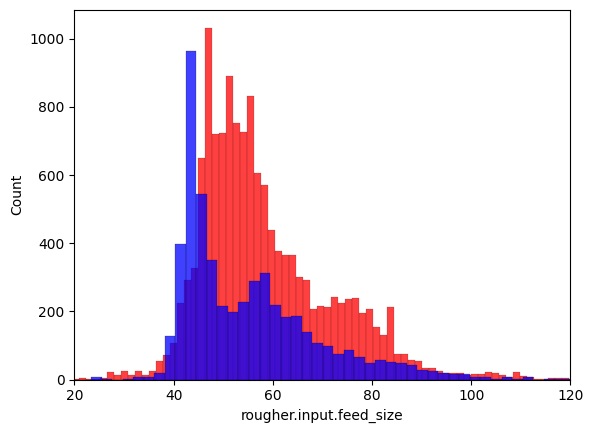

In [31]:
sns.histplot(df_train[f'rougher.input.feed_size'], color='r', label='Сырье', kde=False)
sns.histplot(df_test[f'rougher.input.feed_size'], color='b', label='Концентрация после флотации', kde=False)
plt.xlim(left = 20, right = 120)
plt.show()

* Распределения в тестовой и тренировочной выборках схожи, мы сможем корректно протестировать модель.

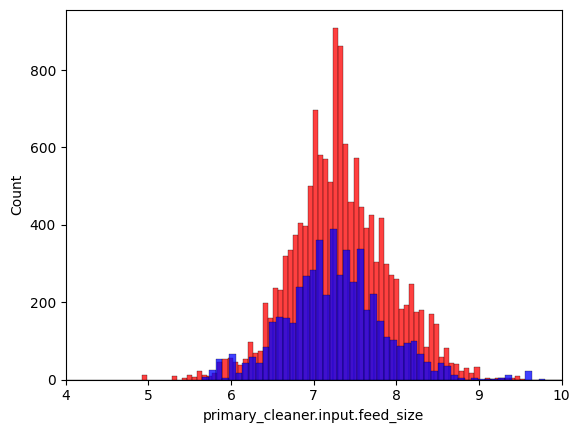

In [32]:
sns.histplot(df_train[f'primary_cleaner.input.feed_size'], color='r', label='Сырье', kde=False)
sns.histplot(df_test[f'primary_cleaner.input.feed_size'], color='b', label='Концентрация после флотации', kde=False)
plt.xlim(left = 4, right = 10)
plt.show()

На выходе распределение так же схоже, поэтому сможем корректно построить модель.

#### 2.3. Исследуйте суммарную концентрацию всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах.  
Этапы:  
raugh_input_feed -> raugh_output_concentrate -> final_output_concentrate

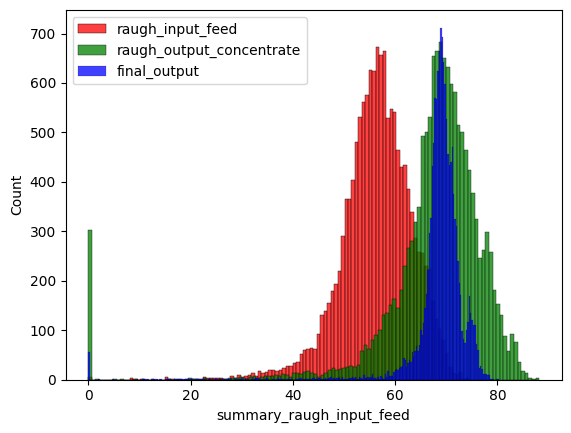

In [33]:
df_summary_train = df_train.copy()

#raugh_input:
df_summary_train['summary_raugh_input_feed']=df_summary_train['rougher.input.feed_au']+\
    df_summary_train['rougher.input.feed_ag']+\
    df_summary_train['rougher.input.feed_pb']+\
    df_summary_train['rougher.input.feed_sol']

#raugh_output:
df_summary_train['summary_raugh_output_concentrate']=df_summary_train['rougher.output.concentrate_au']+\
    df_summary_train['rougher.output.concentrate_ag']+\
    df_summary_train['rougher.output.concentrate_pb']+\
    df_summary_train['rougher.output.concentrate_sol']

#final_output:
df_summary_train['summary_final_output_concentrate']=df_summary_train['final.output.concentrate_au']+\
    df_summary_train['final.output.concentrate_ag']+\
    df_summary_train['final.output.concentrate_pb']+\
    df_summary_train['final.output.concentrate_sol']

sns.histplot(df_summary_train[f'summary_raugh_input_feed'], color='r', label='raugh_input_feed', kde=False)
sns.histplot(df_summary_train[f'summary_raugh_output_concentrate'], color='g', label='raugh_output_concentrate', kde=False)
sns.histplot(df_summary_train[f'summary_final_output_concentrate'], color='b', label='final_output', kde=False)

plt.legend(loc = 'upper left')
plt.show()


Мы видим, что на финальном этапе концентрация металлов располагается вокруг значения 70, при этом доля ag как мы видели раньше снижается. 

### Часть 3. Построение модели

#### 3.1 Напишите функцию для вычисления итоговой sMAPE.

In [34]:
display('Метрика sMAPE:', Image(url='https://pictures.s3.yandex.net/resources/smape_1576238825.jpg',width = 800))

'Метрика sMAPE:'

In [35]:
def smape(target, predict):
    return 1/len(target)*np.sum((np.abs(target-predict))/((np.abs(target)+np.abs(predict))/2))*100

In [36]:
display('Итоговая метрика складывается из двух величин::', Image(url='https://pictures.s3.yandex.net/resources/_smape_1576238814.jpg',width = 800))

'Итоговая метрика складывается из двух величин::'

In [37]:
def final_smape(rougher, final):
    return 0.25*rougher+0.75*final

#### 3.2. Обучите разные модели и оцените их качество кросс-валидацией. Выберите лучшую модель и проверьте её на тестовой выборке. Опишите выводы.

In [38]:
#Разделим тренировочную выборку на признаки и таргет
X_train = df_train[train_cols].drop('date',axis=1)
y_train_rougher = df_train['rougher.output.recovery']
y_train_final = df_train['final.output.recovery']

smape_score = make_scorer(smape, greater_is_better= False )

##### Линейная регрессия

In [39]:
smape_scorer = make_scorer(smape )


In [40]:
model_lr_rougher = LinearRegression()
scores_lr_rougher = cross_val_score(model_lr_rougher,  
    X_train, 
    y_train_rougher, 
    scoring = smape_scorer,
    cv = 5)
smape_rougher = np.mean(abs(scores_lr_rougher))    
print('Средняя оценка качества sMape_rougher', round(smape_rougher, 4))

Средняя оценка качества sMape_rougher 12.9135


In [41]:
model_lr_final = LinearRegression()
scores_lr_final = cross_val_score(model_lr_final,  
    X_train, 
    y_train_final, 
    scoring = smape_scorer,
    cv = 5)
smape_final = np.mean(abs(scores_lr_final))    
print('Средняя оценка качества sMape_rougher', round(smape_final, 4))

Средняя оценка качества sMape_rougher 12.113


In [42]:
smape_total = final_smape(smape_rougher,smape_final)
smape_total


12.313166841631034

##### Дерево решений

In [43]:
best_result_for_dt = 100
best_param_for_dt = 0
for n in range(1, 12, 1):
    model_dt_rougher = DecisionTreeRegressor(max_depth=n, random_state=RandomState(12345))
    smape_rougher = cross_val_score(model_dt_rougher,
                              X_train,
                              y_train_rougher,
                              scoring=smape_scorer,
                              cv=4)
    smape_rougher = smape_rougher.mean()

    model_dt_final = DecisionTreeRegressor(max_depth=n, random_state=RandomState(12345))
    smape_final = cross_val_score(model_dt_final, 
                                  X_train,
                                  y_train_final,
                                  scoring=smape_scorer,
                                  cv=4)
    smape_final = smape_final.mean()
    result_smape = final_smape(smape_rougher, smape_final)
    if result_smape < best_result_for_dt:
        best_result_for_dt = result_smape
        best_param_for_dt = n
display (best_result_for_dt, best_param_for_dt)

11.276409665809489

2

И тут я поплыл, почему-то smape стало отрицательным. Подскажите, пожалуйста, в правильном ли направлении я двигаюсь. 
Также не понял, является ли smape 12 хорошим или плохим значением для первой модели. Не очень понимаю, как потом сравнивать ее с -17..